# Gamma Poisson Simulation

This code implements the Gamma Poisson simulation studied in the paper.

In [1]:
# import mathematical libraries
import numpy as np
from scipy.stats import gamma, nbinom, poisson
import warnings
warnings.filterwarnings('ignore')

# configure plotting environment
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=120)
%matplotlib inline
from mpltools import style, layout
style.use('ggplot')
plt.rcParams['figure.figsize'] = 16, 5
import itertools

## Simulate data from Population


In [2]:
# First Poisson
lam = 5
N   = 100

# Second Poisson
lam_fail = 50
N_fail   = 5

# Draw the data
data           = np.random.poisson(lam, N)
data[0:N_fail] = np.random.poisson(lam_fail, N_fail) 

## Define prior parameters

In [4]:
# Gamma prior parameters
a = 2.5
b = 0.5

# Empirical Bayes Gamma prior parameters
data_mean = np.mean(data)
data_var  = np.var(data)

a_eb = data_mean**2/data_var
b_eb = data_mean/data_var

## Calculate posterior and predictive densities

In [5]:
# Bayesian model
# Gamma posterior parameters
aN = a + np.sum(data)
bN = b + N

# Empirical Bayes model
# Gamma posterior parameters
a_ebN = a_eb + np.sum(data)
b_ebN = b_eb + N

# POP-EB
# Number of bootstrap samples for POP-EB densities
B = 100

# Pre-allocate memory
x = np.linspace(0, 11, 250) # x-axis values for posterior densities
xdiscrete = range(58)       # x-axis values for predictive densities

data_bt = np.zeros((N,B), dtype='int32')

marginal_posterior   = np.zeros_like(x)
weighted_posterior   = np.zeros_like(x)
bootstrap_posteriors = np.zeros((x.size,B))

marginal_predictive  = np.array(np.zeros_like(xdiscrete), dtype='double')
weighted_predictive  = np.array(np.zeros_like(xdiscrete), dtype='double')

predictive_scores = np.zeros((B))

atmp = np.zeros((B))
btmp = np.zeros((B))
for index in range(B):
    bt = np.random.choice(data,data.size)
    abt = a + np.sum(bt)
    bbt = (b + N)
    
    atmp[index] = abt
    btmp[index] = bbt
    data_bt[:,index] = bt
    
    bootstrap_posteriors[:,index] = gamma.pdf( x, abt, scale = 1.0/bbt )
    predictive_scores[index]      = np.sum( np.log( nbinom.pmf(data, abt, 1.0/(1.0+1.0/bbt)) + 1e-6 ) )
    
    marginal_posterior  += 1.0/B * bootstrap_posteriors[:,index]
    marginal_predictive += 1.0/B * nbinom.pmf(xdiscrete, abt, 1.0/(1.0+1.0/bbt))
    
weights = np.exp(predictive_scores) / np.sum(np.exp(predictive_scores))
for index in range(B):
    weighted_posterior  += weights[index] * bootstrap_posteriors[:,index]
    weighted_predictive += weights[index] * nbinom.pmf(xdiscrete, atmp[index], 1.0/(1.0+1.0/btmp[index]))
        
bumpindex = np.argmax(predictive_scores)

## Plots

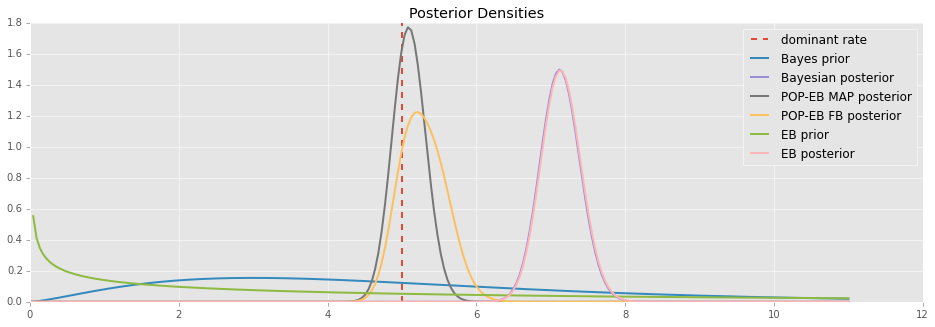

In [9]:
# Posterior densities
fig, ax = plt.subplots(1,1)
ax.set_title('Posterior Densities')
layout.cross_spines(ax=ax)
colors = itertools.cycle(plt.rcParams['axes.color_cycle'])
    
thiscolor = next(colors)
ax.axvline(lam, color=thiscolor, lw=2, ls='--', label='dominant rate')
thiscolor = next(colors)
ax.plot(x, gamma.pdf(x,a,scale=1.0/b), color=thiscolor, lw=2, label='Bayes prior')
thiscolor = next(colors)
ax.plot(x, gamma.pdf(x,aN,scale=1.0/bN), color=thiscolor, lw=2, label='Bayesian posterior')
thiscolor = next(colors)
ax.plot(x, bootstrap_posteriors[:,bumpindex], color=thiscolor, lw=2, label='POP-EB MAP posterior')
thiscolor = next(colors)
ax.plot(x, weighted_posterior, color=thiscolor, lw=2, label='POP-EB FB posterior')
thiscolor = next(colors)
ax.plot(x, gamma.pdf(x,a_eb,scale=1.0/b_eb), color=thiscolor, lw=2, label='EB prior')
thiscolor = next(colors)
ax.plot(x, gamma.pdf(x,a_ebN,scale=1.0/b_ebN), color=thiscolor, lw=2, label='EB posterior')

ax.legend(loc=1)

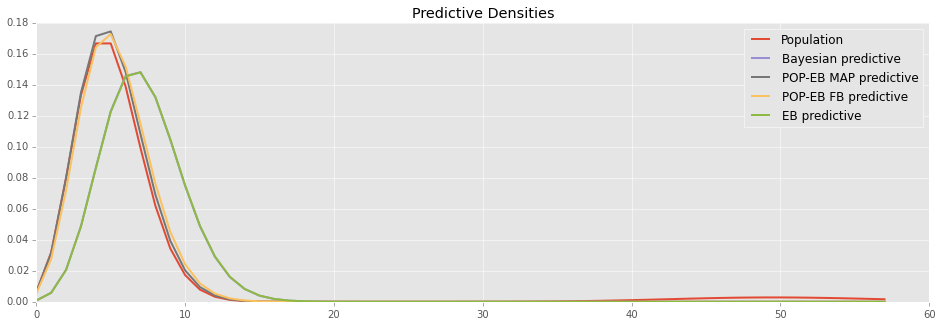

In [10]:
# Predictive densities
fig, ax = plt.subplots(1,1)
ax.set_title('Predictive Densities')
layout.cross_spines(ax=ax)
colors = itertools.cycle(plt.rcParams['axes.color_cycle'])

thiscolor = next(colors)
ax.plot(xdiscrete, 
        (float(N-N_fail)/N)*poisson.pmf(xdiscrete, lam) +
        (float(N_fail)/N)*poisson.pmf(xdiscrete, lam_fail), color=thiscolor, lw=2, label='Population')
thiscolor = next(colors)
thiscolor = next(colors)
ax.plot(xdiscrete, nbinom.pmf(xdiscrete, aN, 1.0/(1.0+1.0/bN)), color=thiscolor, lw=2, label='Bayesian predictive')
thiscolor = next(colors)
ax.plot(xdiscrete, nbinom.pmf(xdiscrete, atmp[bumpindex], 1.0/(1.0+1.0/btmp[bumpindex])), color=thiscolor, lw=2, label='POP-EB MAP predictive')
thiscolor = next(colors)
plt.plot(xdiscrete,
         weighted_predictive,
         color=thiscolor, lw=2, label='POP-EB FB predictive')
thiscolor = next(colors)
ax.plot(xdiscrete, nbinom.pmf(xdiscrete, a_ebN, 1.0/(1.0+1.0/b_ebN)), color=thiscolor, lw=2, label='EB predictive')
ax.legend(loc=1)
